In [1]:
#!/usr/bin/env python3
"""
Neven Caplar 
Last updated: 2023-11-30

Goals: 
Fit the Tape Single data

What this notebook currently does
--------------------------------
1 Analyzes the g-band data from Tape Single Pixel

What this notebook will do in the future
--------------------------------
Add analysis for all bands

What is TODO:
--------------------------------
Check the results; they seems to be unreasonable for some lightcurves

Open questions:
--------------------------------
None at the moment

Extra notes:
--------------------------------
Each Section can/should run independently,
only initial imports should be shared among all sections
"""

import os

import numpy as np
import pandas as pd
import pyarrow as pa

# from scipy.spatial import KDTree
import matplotlib.pyplot as plt

import JaxPeriodDrwFit


from tape.ensemble import Ensemble
from tape.utils import ColumnMapper

from tqdm import tqdm

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [2]:
import dask
# many workers
# dask.config.set(scheduler='threads') 

# dask.config.set({"temporary-directory" :'/epyc/ssd/users/ncaplar/tmp'})

# does not work
# from multiprocessing.pool import ThreadPool
# dask.config.set(pool=ThreadPool(20))

# one worker
# dask.config.set(scheduler='processes')  
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=12, threads_per_worker=1)
client = Client(cluster)
# cluster.adapt(minimum=10, maximum=40) 

/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45886 instead
  warnings.warn(


In [3]:
dask.config.get("temporary-directory")

In [4]:
ens = Ensemble(client = client)  # initialize an ensemble object
ens.client_info()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:45886/status,
Dashboard: http://127.0.0.1:45886/status,Workers: 12
Total threads: 12,Total memory: 251.68 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40007,Workers: 12
Dashboard: http://127.0.0.1:45886/status,Total threads: 12
Started: Just now,Total memory: 251.68 GiB
Comm: tcp://127.0.0.1:44774,Total threads: 1
Dashboard: http://127.0.0.1:33521/status,Memory: 20.97 GiB
Nanny: tcp://127.0.0.1:38207,


In [5]:
dask.config.get("temporary-directory")

In [6]:
# Setup base directory for saving output files
username= "ncaplar"
basedir = f"/astro/users/{username}/data/"

# Tape Single Pixel

In [8]:
# if running on baldur or epyc
data_path = "/astro/store/epyc/data3/hipscat/catalogs/tape_test/"

col_map = ColumnMapper(id_col="SDSS_NAME_dr16q_constant", 
                       time_col="mjd_ztf_source",
                       flux_col="mag_ztf_source", 
                       err_col="magerr_ztf_source",
                       band_col="band_ztf_source")

ens.from_hipscat(data_path,
                 source_subdir="tape_test_sources",
                 object_subdir="tape_test_obj",
                 column_mapper=col_map,
                 additional_cols=True,
                 sync_tables=False,
                 sort=True,
                 )

In [9]:
ens.query("band_ztf_source == 'g'", table = 'source')
ens.prune(10)
ens.query("rMeanPSFMag_ps1_otmo < 20", table = 'object')

In [10]:
ens.source.divisions

('023744.13+000118.5',
 '024109.99-002251.6',
 '024242.51-002212.9',
 '024425.39-004653.0',
 '024827.53-000136.8')

(17.0, 21.0)

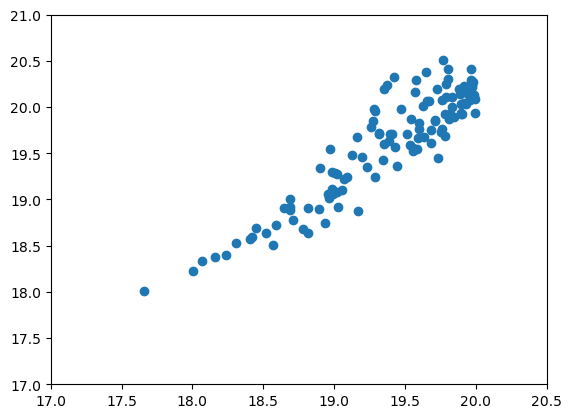

In [11]:
plt.scatter(ens.object['rMeanPSFMag_ps1_otmo'].compute().values, ens.object['gMeanPSFMag_ps1_otmo'].compute().values)
plt.xlim(17,20.5)
plt.ylim(17,21)

(17.0, 23.0)

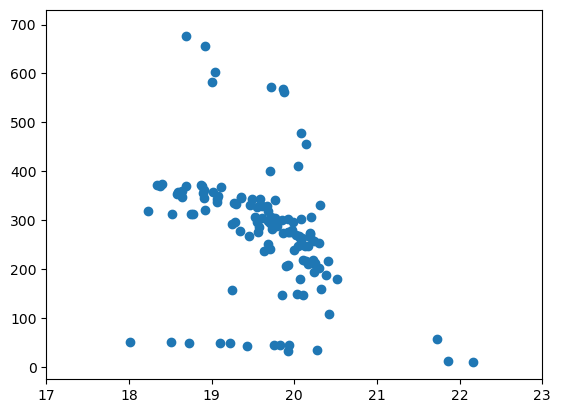

In [13]:
ens_nobs = ens.calc_nobs(temporary=False)

plt.scatter( ens.object['gMeanPSFMag_ps1_otmo'].compute().values,ens_nobs.object['nobs_total'].compute().values)
plt.xlim(17,23)

(array([ 4.,  9.,  4.,  0.,  1.,  0.,  2.,  3.,  3.,  4.,  7.,  6.,  8.,
        13., 14.,  7., 17.,  7.,  6.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
         0.,  2.,  2.,  1.,  0.,  0.,  1.,  1.,  1.]),
 array([ 10.,  30.,  50.,  70.,  90., 110., 130., 150., 170., 190., 210.,
        230., 250., 270., 290., 310., 330., 350., 370., 390., 410., 430.,
        450., 470., 490., 510., 530., 550., 570., 590., 610., 630., 650.,
        670., 690., 710.]),
 <BarContainer object of 35 artists>)

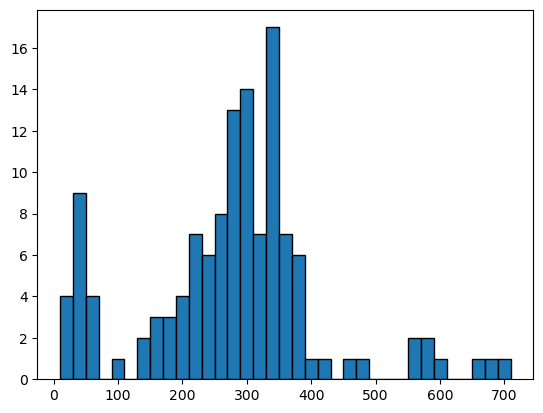

In [14]:
data = ens_nobs.object['nobs_total'].compute().values

bin_edges = range(min(data), max(data) + 21, 20) 
plt.hist(data, bins=bin_edges, edgecolor='k')  # 'k' sets black color for edges

## computation

In [15]:
# 9min, 13 sec on baldur, for 603 sources in 4 partitions
# 7min, 30 sec on baldur, for 603 sources in 4 partitions, Nov 7
# 5min, 14 sec on baldur, for 603 sources in 10 partitions, Nov 7
# 2min, 50 sec on baldur, for 127 sources in 4 partitions
# 5min, 3 sec on epyc, for 127 sources in 4 partitions
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
res_tsp = ens.batch(JaxPeriodDrwFit_instance.optimize_map, 'mjd_ztf_source', "mag_ztf_source", "magerr_ztf_source",
                compute=True, meta=None, n_init=100)

Using generated label, result_1, for a batch result.


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [16]:
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
res_tsp_drw = ens.batch(JaxPeriodDrwFit_instance.optimize_map_drw, 'mjd_ztf_source', "mag_ztf_source", "magerr_ztf_source",
                compute=True, meta=None, n_init=100)

Using generated label, result_2, for a batch result.


In [17]:
def pack_output_to_parquet(result, cols, output_dir, output_filename, drop_cols=[], full=False):
    """Packs output to a dataframe, written as a parquet file. The created dataframe object is returned for inspection."""
    result_df = None
    if full:
        # Construct dataframes with the results for each object.
        dfs = []
        for i in range(len(result)):
            obj_data = result.iloc[i]
            # Construct a series representing the index
            obj_index = pd.Series(np.full(len(obj_data), result.index[i]), name=result.index.name)
            dfs.append(pd.DataFrame(data=obj_data, columns=cols, index=obj_index))

        # Concatenate all of the per-object dataframes
        result_df = pd.concat(dfs)
    else:
        # Each object only has a 1D array in the result series, so the constructed
        # dataframe has the same number of rows. So we can just do a 1:1 mapping with column names 
        result_df = pd.DataFrame(columns=cols, index=result.index)
        for i in range(len(result)):
            result_df.iloc[i] = result[i]

    # Drop any columns if requested.
    if drop_cols:
        result_df = result_df.drop(columns=drop_cols)

    # Write the output to the parquet file
    pa_table = pa.Table.from_pandas(result_df)
    pa_table
    pa.parquet.write_table(pa_table, f"{output_dir}/data/{output_filename}.parquet")
    return result_df

# Create columns for result of using just the drw kernel
param_cols = ['log_drw_scale', 'log_drw_amp']
init_param_cols = ["init_" + c for c in param_cols]
drw_columns = ['min_neg_log_lh', 'neg_log_lh'] + param_cols + init_param_cols

# Create columns for result of combining the drw params with periodic params
param_cols = ['log_drw_scale', 'log_drw_amp', 'log_per_scale', 'log_per_amp']
init_param_cols = ["init_" + c for c in param_cols]
combined_columns = ['min_neg_log_lh', 'neg_log_lh'] + param_cols + init_param_cols

In [ ]:
# v2 - included subrtraction of t = -t[0]

In [18]:
# Save output for results from just the drw kernel
drw_df = pack_output_to_parquet(res_tsp_drw, drw_columns,
                       f"/astro/users/{username}", "res_tsp_run_g_2_drw")
drw_df

,min_neg_log_lh,neg_log_lh,log_drw_scale,log_drw_amp,init_log_drw_scale,init_log_drw_amp
SDSS_NAME_dr16q_constant,,,,,,
023759.19+000044.2,-63.245313,-63.245313,2.688159,-0.918292,0.780093,1.537832
023813.09+000832.8,-52.103274,-52.103274,3.044007,-0.819715,4.847923,1.541329
023835.35-000154.6,-55.755721,-55.755721,2.579811,-1.317469,1.404673,-2.548551
023848.09-001132.6,28.551746,28.551746,2.515514,-1.389846,1.460723,-1.409983
023849.38+000701.0,5.553518,5.553518,2.354445,-1.295228,2.623782,-2.06715
...,...,...,...,...,...,...
024717.41-000052.4,-18.945155,-18.945155,2.873429,-0.962429,1.783767,-0.321127
024719.36+000014.5,26.022219,26.022219,-9.971319,-5.00919,0.979914,0.808098
024727.53-001041.5,-18.053187,-18.053187,2.734043,-1.07811,0.998369,1.090074


In [19]:
# Save output for results from the combined drw and periodic kernel
combined_df = pack_output_to_parquet(res_tsp, combined_columns,
                       f"/astro/users/{username}", "res_tsp_run_g_2")
combined_df

,min_neg_log_lh,neg_log_lh,log_drw_scale,log_drw_amp,log_per_scale,log_per_amp,init_log_drw_scale,init_log_drw_amp,init_log_per_scale,init_log_per_amp
SDSS_NAME_dr16q_constant,,,,,,,,,,
023759.19+000044.2,-64.350836,-64.350836,2.925709,-0.981494,2.850561,-1.235303,2.361075,-1.790739,2.954166,-0.781204
023813.09+000832.8,-53.042001,-53.042001,2.579005,-1.137745,3.556189,-0.904959,0.704621,-1.3961,3.485079,-0.356726
023835.35-000154.6,-56.748207,-56.748207,1.813808,-24.930584,3.181574,-1.311388,0.226136,-1.811812,2.850306,-0.414367
023848.09-001132.6,28.140307,28.140307,-7.140811,-6.138879,3.248844,-1.354281,4.162213,1.648488,3.259806,-2.930285
023849.38+000701.0,4.992978,4.992978,2.223533,-1.762481,3.153051,-1.329095,0.232252,-0.446263,3.155693,-2.31874
...,...,...,...,...,...,...,...,...,...,...
024717.41-000052.4,-21.170046,-21.170046,12.56383,-1.353869,3.255682,-1.008374,2.806386,0.165507,1.800953,-0.864864
024719.36+000014.5,24.386554,24.386554,-11.373365,-6.53455,2.602535,-1.143805,1.521211,1.01836,1.626998,-1.875379
024727.53-001041.5,-20.094219,-20.094219,2.63905,-1.513356,2.638773,-1.107925,3.534287,0.225864,2.556712,-2.804231


## Redo but save all results (full=True) - only version 0 done

In [ ]:
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
res_tsp_full = ens.batch(JaxPeriodDrwFit_instance.optimize_map, 'mjd_ztf_source', "mag_ztf_source", "magerr_ztf_source",
                compute=True, meta=None, n_init=100, full=True)

In [ ]:
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
res_tsp_drw_full = ens.batch(JaxPeriodDrwFit_instance.optimize_map_drw, 'mjd_ztf_source', "mag_ztf_source", "magerr_ztf_source",
                compute=True, meta=None, n_init=100, full=True)

In [ ]:
# Save output for results from just the drw kernel
drw_df_full = pack_output_to_parquet(res_tsp_drw_full, drw_columns,
                       f"/astro/users/{username}", "res_tsp_run_g_0_drw_full", full=True)
drw_df_full

In [ ]:
# Save output for results from the combined drw and periodic kernel
combined_df_full = pack_output_to_parquet(res_tsp_full, combined_columns,
                       f"/astro/users/{username}", "res_tsp_run_g_0_full", full=True)
combined_df_full

In [1]:
res_tsp

NameError: name 'res_tsp' is not defined